In [ ]:
# Creating the database

In [7]:
!haystack --version

haystack, version 1.23.0


2023-12-16 18:48:17.163395: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



In [ ]:
# Meditations Marcus Aurelius
# Source: https://raw.githubusercontent.com/jamescalam/transformers/main/data/text/meditations/clean.txt

In [1]:
import requests

In [2]:
data = requests.get('https://raw.githubusercontent.com/renatovillela93/RAG_OpenAI/main/All_data_LandscapeArchitec.txt')
text = data.text.split('\\n')

In [4]:
text[:-1]

['BIM Education in Landscape Architecture: The Rapperswil Model ',
 'Abstract',
 'In 2016, Switzerland decided to embrace digitization in every industry, in all sectors, and at \\r',
 "all  levels.  Within  the  Landscape  Architecture  program  at  the  OST  University  of  Applied  Sciences, teaching and research with strong emphasis on Digital Construction had already been carried out for years. In view of the country’s vigorous drive towards digitization and being the only bachelor's pro-\\r",
 'gram in the German-speaking part of Switzerland, Rapperswil Landscape Architecture is committed to \\r',
 'partake and to aid in this digitization process. The paper gives an overview of Digital Construction in \\r',
 'Landscape Architecture education in Rapperswil, status 2022.',
 '',
 'Introduction ',
 'In the coming years, the construction industry worldwide will undergo digital transformation. ',
 'Building Information Modeling (BIM) plays a central role with the digital twin and with a

In [5]:
# Connecting ElasticSearch and Haystack

from haystack.document_stores import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(host = "localhost",
                                            port = 9200,
                                            username='your_user_name', password='your_password',
                                           )

In [6]:
requests.get('http://localhost:9200/_cluster/health', auth=('your_user_name','your_password')).json()

{'cluster_name': 'elasticsearch',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 5,
 'active_shards': 5,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 4,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 55.55555555555556}

In [7]:
print(requests.get('http://localhost:9200/_cat/indices', auth=('your_user_name','your_password')).text)

yellow open label     sxDxkH-ZRtmZjtkUb6zX5Q 1 1    0    0    249b    249b    249b
yellow open architect IFWlHfKyQUa7Z97enAKpyQ 1 1 3944 5071   1.3mb   1.3mb   1.3mb
yellow open aurelius  9X7J03rOQbyAtC_XX9GigA 1 1  507    0 328.3kb 328.3kb 328.3kb
yellow open document  7OsBfM9oSAK55LfsZux6tQ 1 1    0    0    249b    249b    249b



In [12]:
# Building the pipeline

doc_store = ElasticsearchDocumentStore(
    host='localhost',
    username='rnt93', password='123456',
    index='architect'
)

In [8]:
print(requests.get('http://localhost:9200/_cat/indices', auth=('your_user_name','your_password')).text)

yellow open label     sxDxkH-ZRtmZjtkUb6zX5Q 1 1    0    0    249b    249b    249b
yellow open architect IFWlHfKyQUa7Z97enAKpyQ 1 1 3944 5071   1.3mb   1.3mb   1.3mb
yellow open aurelius  9X7J03rOQbyAtC_XX9GigA 1 1  507    0 328.3kb 328.3kb 328.3kb
yellow open document  7OsBfM9oSAK55LfsZux6tQ 1 1    0    0    249b    249b    249b



In [9]:
# List comprehension to extract information from text and create list of dict
data_json = [
    {
        'content': paragraph,
        'meta': {
            'source': 'papers'
        }
    } for paragraph in text
]

In [20]:
data_json[:2]

[{'content': 'BIM Education in Landscape Architecture: The Rapperswil Model ',
  'meta': {'source': 'papers'}},
 {'content': 'Abstract', 'meta': {'source': 'papers'}}]

In [23]:
help(ElasticsearchDocumentStore)

Help on class ElasticsearchDocumentStore in module haystack.document_stores.elasticsearch.es8:

class ElasticsearchDocumentStore(haystack.document_stores.elasticsearch.base._ElasticsearchDocumentStore)
 |  ElasticsearchDocumentStore(host: Union[str, List[str]] = 'localhost', port: Union[int, List[int]] = 9200, username: str = '', password: str = '', api_key_id: Optional[str] = None, api_key: Optional[str] = None, aws4auth=None, index: str = 'document', label_index: str = 'label', search_fields: Union[str, list] = 'content', content_field: str = 'content', name_field: str = 'name', embedding_field: str = 'embedding', embedding_dim: int = 768, custom_mapping: Optional[dict] = None, excluded_meta_data: Optional[list] = None, analyzer: str = 'standard', scheme: str = 'http', ca_certs: Optional[str] = None, verify_certs: bool = True, recreate_index: bool = False, create_index: bool = True, refresh_type: str = 'wait_for', similarity: str = 'dot_product', timeout: int = 300, return_embedding:

In [13]:
# Writing in ElasticSearch format

doc_store.write_documents(data_json)

In [28]:
# Confirm if we upload all data

print(len(data_json))
print(requests.get('http://localhost:9200/architect/_count', auth=('rnt93','123456')).json())

9512
{'count': 3944, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}


In [ ]:
# https://huggingface.co/deepset/bert-base-cased-squad2

In [14]:
# Alternative 1 - BM25 Retriever

from haystack.nodes import BM25Retriever

retriever_BM25 = BM25Retriever(doc_store)

In [ ]:
# Alternative 2 - Embedding Retriever with pre-trained model

document_store2 = document_store

from haystack.nodes import EmbeddingRetriever

retriever_embedding = EmbeddingRetriever(
    document_store=document_store2, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)

In [ ]:
# Important:
# Now that we initialized the Retriever, we need to call update_embeddings() to iterate over all
# previously indexed documents and update their embedding representation.
# While this can be a time consuming operation (depending on the corpus size), it only needs to be done once.
# At query time, we only need to embed the query and compare it to the existing document embeddings, which is very fast.

document_store2.update_embeddings(retriever)

In [38]:
# Correcting error (cell below run 37): "ImportError: Failed to import 'sentence_transformers'. Run 'pip install farm-haystack[inference]'. Original error: No module named 'sentence_transformers'"

!pip install farm-haystack[inference]

     ---------------------------------------- 0.0/86.0 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/86.0 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/86.0 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/86.0 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/86.0 kB ? eta -:--:--
     ------------- ------------------------ 30.7/86.0 kB 119.1 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/86.0 kB 130.7 kB/s eta 0:00:01
     ------------------------------------ - 81.9/86.0 kB 241.3 kB/s eta 0:00:01
     -------------------------------------- 86.0/86.0 kB 220.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/977.5 kB ? eta -:--:--
     ---- --------------------------------- 122.9/977.5 kB 7.0 MB/s eta 0:00:01
     -------------------- ----------------- 522.2/977.5 kB 5.

In [42]:
!pip install -U sentence-transformers

In [15]:
# Initializing Reader

from haystack.nodes import FARMReader
model_name_or_path = "deepset/roberta-base-squad2"

reader = FARMReader(model_name_or_path, use_gpu=True)

In [16]:
# Alternative 1 - Initializing Pipeline - w/ BM25Retriever

from haystack.pipelines import ExtractiveQAPipeline

qa = ExtractiveQAPipeline(reader, retriever_BM25)

In [ ]:
# Alternative 2 - Initializing Pipeline - w/ Embedding Retriever

from haystack.pipeline import ExtractiveQAPipeline

qa = ExtractiveQAPipeline(reader, retriever_embedding)

In [22]:
qa.run(query='Acoustic grounds are formed landscapes intentionally designed to mitigate noise pollution, what are some limitations to using it as a noise mitigation strategy?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.17s/ Batches]


{'query': 'Acoustic grounds are formed landscapes intentionally designed to mitigate noise pollution, what are some limitations to using it as a noise mitigation strategy?',
 'no_ans_gap': -1.1563305854797363,
 'answers': [<Answer {'answer': 'increasing in height in the direction of the noise dispersion provide less effective mitigation unless they are high enough to form a barrier adjacent to the noise source', 'type': 'extractive', 'score': 0.2155127227306366, 'context': 'increasing in height in the direction of the noise dispersion provide less effective mitigation unless they are high enough to form a barrier adjacent to the noise source', 'offsets_in_document': [{'start': 0, 'end': 170}], 'offsets_in_context': [{'start': 0, 'end': 170}], 'document_ids': ['dfa4c4afcfdebf04889192a7af3a6051'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'public recreational use', 'type': 'extractive', 'score': 0.08789712190628052, 'context': 'forming can provide noise mitigation as well as p

In [23]:
qa.run(query='What blue-green infrastructure design approaches might a landscape architect use to achieve connectivity in an urban landscape to maximize ecological functiont?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.13s/ Batches]


{'query': 'What blue-green infrastructure design approaches might a landscape architect use to achieve connectivity in an urban landscape to maximize ecological functiont?',
 'no_ans_gap': 0.7779295444488525,
 'answers': [<Answer {'answer': 'renewable energy combined with blue and green infrastructure', 'type': 'extractive', 'score': 0.41386842727661133, 'context': 'renewable energy combined with blue and green infrastructure. Land use is planned strategically to mitigate urban sprawl, reduce the urban heat island', 'offsets_in_document': [{'start': 0, 'end': 60}], 'offsets_in_context': [{'start': 0, 'end': 60}], 'document_ids': ['6b8cf2e1124e90a8c1fc86b15f4910b1'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'Urban Green', 'type': 'extractive', 'score': 0.2459712028503418, 'context': 'Integration of Urban Green and Blue Infrastructure by ', 'offsets_in_document': [{'start': 15, 'end': 26}], 'offsets_in_context': [{'start': 15, 'end': 26}], 'document_ids': ['d6b8111987069619c8

In [24]:
qa.run(query='What strategies can be employed by landscape architects to achieve optimal leaf coverage and optimize ecosystem services of urban trees in cities?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.73s/ Batches]


{'query': 'What strategies can be employed by landscape architects to achieve optimal leaf coverage and optimize ecosystem services of urban trees in cities?',
 'no_ans_gap': 7.386897563934326,
 'answers': [<Answer {'answer': 'semi-automated tree planning workflow', 'type': 'extractive', 'score': 0.6840769648551941, 'context': 'a semi-automated tree planning workflow. It is a method for enabling a maximum leaf coverage in cities to increase biomass and ESS without conflicting', 'offsets_in_document': [{'start': 2, 'end': 39}], 'offsets_in_context': [{'start': 2, 'end': 39}], 'document_ids': ['85f1366fe2ce5277b7fb120f9ea8b726'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'adaptive design framework', 'type': 'extractive', 'score': 0.5179020762443542, 'context': 'ecosystem, and encourages landscape architects to develop an adaptive design framework ', 'offsets_in_document': [{'start': 61, 'end': 86}], 'offsets_in_context': [{'start': 61, 'end': 86}], 'document_ids': ['e692bba1ef

In [25]:
qa.run(query='What primary factors must a landscape architect consider when designing small-scale public spaces to optimize landscape performance?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/ Batches]


{'query': 'What primary factors must a landscape architect consider when designing small-scale public spaces to optimize landscape performance?',
 'no_ans_gap': 8.037231683731079,
 'answers': [<Answer {'answer': 'correlative factors', 'type': 'extractive', 'score': 0.7853252291679382, 'context': 'uality of small-scale public spaces, a clear understanding of landscape performance and its correlative factors is necessary. The structural equation ', 'offsets_in_document': [{'start': 144, 'end': 163}], 'offsets_in_context': [{'start': 92, 'end': 111}], 'document_ids': ['7fe102a0bcb6601fbeadd5d21641a645'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'the  weight', 'type': 'extractive', 'score': 0.6151731014251709, 'context': 'analyze  the  weight  of  each  factor  related  to  landscape  performance  of  small-scale  public ', 'offsets_in_document': [{'start': 9, 'end': 20}], 'offsets_in_context': [{'start': 9, 'end': 20}], 'document_ids': ['11dcf00c13d1f99c0cdeacbe68828cdd'], 'me

In [26]:
qa.run(query='Computational tree modeling is the process of creating dynamic, scientifically informed and visually realistic digital representations of trees. What are the potential applications of this technology in urban planning and landscape architecture?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/ Batches]


{'query': 'Computational tree modeling is the process of creating dynamic, scientifically informed and visually realistic digital representations of trees. What are the potential applications of this technology in urban planning and landscape architecture?',
 'no_ans_gap': 5.568745374679565,
 'answers': [<Answer {'answer': 'user-specific research', 'type': 'extractive', 'score': 0.8362619280815125, 'context': 'many potential applications of user-specific research in the context of landscape architecture. ', 'offsets_in_document': [{'start': 31, 'end': 53}], 'offsets_in_context': [{'start': 31, 'end': 53}], 'document_ids': ['ae293296a9de077ee95dfef86179edd2'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'conservation planning, and landscape design', 'type': 'extractive', 'score': 0.18266388773918152, 'context': 'sualizing data is critical for the future of digital landscape architecture, conservation planning, and landscape design. This ability to capture and ', 'offsets_in_doc

In [27]:
qa.run(query='What landscape qualities influence economic vitality of retail chains and how might we measure this at both the micro and macro scale?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.06s/ Batches]


{'query': 'What landscape qualities influence economic vitality of retail chains and how might we measure this at both the micro and macro scale?',
 'no_ans_gap': 6.925454139709473,
 'answers': [<Answer {'answer': 'scale and signage', 'type': 'extractive', 'score': 0.9242010116577148, 'context': 'd surveys. Results indicate that micro-level perceived landscape qualities, such as scale and signage, have a greater impact on economic vitality than', 'offsets_in_document': [{'start': 133, 'end': 150}], 'offsets_in_context': [{'start': 84, 'end': 101}], 'document_ids': ['45ca3416d3a45b59cc6fe43c8d21bbaa'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'perceived environment qualities', 'type': 'extractive', 'score': 0.6871361136436462, 'context': 'pe qualities. Further research is needed to investigate how perceived environment qualities contribute to the economic vitality of coffee retail at a ', 'offsets_in_document': [{'start': 77, 'end': 108}], 'offsets_in_context': [{'start': 60

In [28]:
qa.run(query='How can virtual reality (VR) technology be further developed and utilized to create more accessible and user-friendly urban and natural environments for individuals with sensory impairments or different sensory experiences?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/ Batches]


{'query': 'How can virtual reality (VR) technology be further developed and utilized to create more accessible and user-friendly urban and natural environments for individuals with sensory impairments or different sensory experiences?',
 'no_ans_gap': -1.6712039113044739,
 'answers': [<Answer {'answer': 'Representation and Design Studies', 'type': 'extractive', 'score': 0.195956751704216, 'context': 'Virtual Reality (VR) Representation and Design Studies ', 'offsets_in_document': [{'start': 21, 'end': 54}], 'offsets_in_context': [{'start': 21, 'end': 54}], 'document_ids': ['1f002ed3482908f58f446d022694e97c'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'exploration of controlled virtual environments', 'type': 'extractive', 'score': 0.11547023057937622, 'context': 'and task contexts. This suggestion supports further exploration of controlled virtual environments as potentially faster, cheaper, and more convenient', 'offsets_in_document': [{'start': 89, 'end': 135}], 'offsets_in

In [29]:
qa.run(query='What role will Artificial Intelligence (AI) and Machine Learning (ML) play in shaping future landscape design and planning?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.57s/ Batches]


{'query': 'What role will Artificial Intelligence (AI) and Machine Learning (ML) play in shaping future landscape design and planning?',
 'no_ans_gap': -5.580873489379883,
 'answers': [<Answer {'answer': 'the next frontier', 'type': 'extractive', 'score': 0.04895257204771042, 'context': '2021). Artificial intelligence (AI) is the next frontier in digital design technology with the ', 'offsets_in_document': [{'start': 39, 'end': 56}], 'offsets_in_context': [{'start': 39, 'end': 56}], 'document_ids': ['5e0a41caee10b28ef8728b0dd85a2364'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'facilitate new learning and teaching methods', 'type': 'extractive', 'score': 0.03576519712805748, 'context': 'ven artificial intelligence (AI) based methods might facilitate new learning and teaching methods by providing real-time quantitative and qualitative ', 'offsets_in_document': [{'start': 89, 'end': 133}], 'offsets_in_context': [{'start': 53, 'end': 97}], 'document_ids': ['25da72ea4d8cc00f4d24

In [30]:
qa.run(query='How can landscape architects incorporate parametric design and other computational tools into their practice?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/ Batches]


{'query': 'How can landscape architects incorporate parametric design and other computational tools into their practice?',
 'no_ans_gap': 3.51346492767334,
 'answers': [<Answer {'answer': 'digital design practice', 'type': 'extractive', 'score': 0.5597280263900757, 'context': 'gn processes. Landscape architecture, now maturing with its own digital design practice  including  computational  design  (popularly  described  as  ', 'offsets_in_document': [{'start': 72, 'end': 95}], 'offsets_in_context': [{'start': 64, 'end': 87}], 'document_ids': ['984f56e2db5dc57b5be483f8fff549bd'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'respond to ever-evolving nature of practice and their resulting consequences', 'type': 'extractive', 'score': 0.3604123294353485, 'context': 'nd landscape architecture itself can respond to ever-evolving nature of practice and their resulting consequences. The outcomes of this design studio ', 'offsets_in_document': [{'start': 59, 'end': 135}], 'offsets_in_c

In [31]:
qa.run(query='How can we use algorithms to design landscapes that maximize ecological performance?')

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/ Batches]


{'query': 'How can we use algorithms to design landscapes that maximize ecological performance?',
 'no_ans_gap': -0.18916893005371094,
 'answers': [<Answer {'answer': 'Performance-based  design', 'type': 'extractive', 'score': 0.32526546716690063, 'context': 'space-making  and  environmental  challenges  of  design.  Performance-based  design  underscores the value of environmental performance that reflects', 'offsets_in_document': [{'start': 59, 'end': 84}], 'offsets_in_context': [{'start': 59, 'end': 84}], 'document_ids': ['745a965f71a6c8ef92c481cebbb3cb3d'], 'meta': {'source': 'papers'}}>,
  <Answer {'answer': 'avoiding trade-offs in ecological landscapes can be interpreted from the relatively high average importance attributes', 'type': 'extractive', 'score': 0.11834251135587692, 'context': ' how people’s choices and how avoiding trade-offs in ecological landscapes can be interpreted from the relatively high average importance attributes. ', 'offsets_in_document': [{'start': 65, 'e

In [32]:
# ROUGE METRICS

!pip install rouge-score

# Future Ideas
# https://haystack.deepset.ai/tutorials/05_evaluation

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24972 sha256=80d3ad9ccab1d95d15457befb3504119cb8a0acfd2bbd54929fb488704335286
  Stored in directory: c:\users\renat\appdata\local\pip\cache\wheels\1e\19\43\8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [35]:
!pip install rouge

In [36]:
from rouge import Rouge

# Initialize the Rouge object
rouge = Rouge()

# Creating model_out and reference lists
from tqdm import tqdm 

model_out=[]
reference=[]

In [45]:
# List of dicts - Answers

answers = [{'predicted': 'Acoustic grounds that increase in height in the direction of the noise dispersion provide less effective mitigation unless they are high enough to form a barrier adjacent to the noise source. This is because the noise waves will diffract around the top of the ground, and the ground will not be able to absorb the sound waves as effectively.', 
            'true': 'Limitations to using it as a noise mitigation strategy include if there are parameters restricting the height of an acoustic mound, the position of the noise source (emitter) may impact or limit the location of the acoustic mound, the complexity of the parametric mound form, the level of noise absorption of nearby surfaces, and the way different ground covers may contribute to reduction.'},
           {'predicted': 'Landscape architects can achieve connectivity in an urban landscape to maximize ecological function by blending blue and green infrastructure. This can be done by creating green corridors that connect existing green spaces, implementing bioswales and rain gardens to manage stormwater runoff, and restoring natural habitats such as wetlands and forests.',
            'true': 'The main blue-green design approach that can be utilized to maximize ecological function is the revolutionary concept of sponge cities to manage metropolitan challenges such as water cycle management. The paper suggests maximizing consecutive bands of landscape patches. Natural land surfaces should be better connected to freshwater surfaces to maximize ecological function.'},
           {'predicted': 'Implementing a semi-automated tree planning workflow to maximize the spatial occupation of the tree canopy in a dense urban environment. This can be done by using computer modeling to identify the most suitable locations for trees and to optimize their placement.', 
            'true': 'To achieve optimal leaf coverage and optimize ecosystem services of urban trees in cities landscape architects can use the workflow outlined in the article by identifying planting or design targets based on a tree canopys potential volume in allowable growth space. This can be achieved by setting forbidden and allowable space for the canopy with target leaf voxel to achieve optimal spatial occupation of the tree canopy in a dense urban environment. Next using ML, identify specific patterns between adjacent objects (i.e. buildings) and the tree growth rate changes, this can inform tree planting position, species selection and number of trees in an area, this phase is called target-driven tree planting. Finally, maximize ecosystem services (ESS) by executing a detailed tree design and management approach to optimize tree geometry (i.e. branching habit-i.e. pruning).'},
           {'predicted': 'To address the challenges of urbanization and improve the quality of small-scale public spaces, landscape architects must consider four latent factors: Space utilization: This includes the arrangement of spatial elements, such as seating, planting, and circulation paths, to encourage interaction and activity. Spatial quality: This refers to the visual appeal and sensory experience of the space, such as the use of natural materials, lighting, and landscaping. Sense of place: This is the feeling of belonging and identity that people associate with a space, which can be created through the use of landmarks, historical references, and cultural elements. Accessibility and connectivity: This ensures that the space is easily accessible to people of all ages and abilities and that it is well-connected to surrounding neighborhoods and activities.',
            'true': 'The paper outlines four primary factors to optimize landscape performance: Traffic Capacity, Visual Openness, Greening Quality, and Service Capacity. These factors contribute to the balance of traffic, visibility on site, plants diversity,quality and health and amenity or facilities level of service.'},
           {'predicted': 'Computational tree modeling is a rapidly developing field with the potential to revolutionize the way landscape architects design and manage urban environments. This technology allows for the creation of realistic and scientifically accurate digital representations of trees, which can be used for a variety of applications, including Visualization, Simulation, Predictive Modeling, and Interactive tools.', 
            'true': 'The authors hypothesized that point cloud models of trees could be used to improve computational tree growth models. The authors suggest that the use of digital tree models can be used for climatebased performance calculations, such as the U.S. Forest Service Tree Carbon Calculator (USDA 2022). This and other tools allow calculation of carbon dioxide sequestration and aboveground biomass, critical factors in mitigating climate change. This would provide a valuable tool for responsibly determining future performance of urban street trees.,'},
           {'predicted': 'Micro-level perceived landscape qualities, such as scale and signage, have a greater impact on economic vitality than macro-level planning variables. Perceived environment qualities contribute to the economic vitality of coffee retail at a both micro and macro scale.', 
            'true': 'Landscape qualities the authors identified as influencing economic vitality include: Access to transportation such as public transportation facilities, the presence of visitor-oriented urban functions, such as hotels and Airbnb, and the number of Points of Interest (POIs). To measure this, the authors used intensity of geo-tagged catering businesses from Points-of-Interest to measure economic aspects of vitality. The authors also used street view imagery (SVI) using ML algorithms at the macro-scale and crowdsourced surveys at the microscale.,'},
           {'predicted': 'Virtual reality (VR) technology can be further developed and utilized to create more accessible and user-friendly urban and natural environments for individuals with sensory impairments by designing and planning a city to be perceived by all people, including those with sensory impairments. VR can be used to create immersive experiences that allow people to explore these environments and understand how they would be perceived by someone with a sensory impairment. VR can also be used to develop tools that help designers and planners create more inclusive environments.', 
            'true': 'VR technology can be further developed to create more accessible environments by implementing the workflow outlined in the paper. This includes implementing during the design phase, a sonic data collection process, integrating data from multiple geographic points at a site and using the process outlined in the paper to convert the data into a headphone signal that can be integrated into a VR experience. This immersive VR experience as a tool in design workflow can inform specific design decisions to enhance or optimize the sensory experience of all users.,'},
           {'predicted': 'AI and ML are rapidly transforming landscape architecture, with applications in design, urban planning, and transportation planning. Public land managers and landscape architects play a key role in shaping the kinds of activities and experiences that occur in public spaces, and AI can help them to do this more effectively.', 
            'true': 'AI and ML in Digital Design Education will be influenced, as it has in the past, by other disciplines, thinking, tools and techniques. AI and ML will inform and accelerate the transformation of our landscape and urban systems towards a more equitable, resilient and adaptive environment... imbuing the capacity to repair and respond to future crises and to adapt to unpredictable futures.'},
           {'predicted': 'Parametric design and other computational tools can be incorporated into landscape architecture practice in a variety of ways, including enhancing site analysis investigation and design processes, incorporating design research, and enabling the introduction of preciseness into landscape architecture design. These tools can also help landscape architects to overcome roadblocks and incorporate them into the design.', 
            'true': 'Idea generation, concept development and Design can be advanced using the Grasshopper plugin for the Rhino 3D software program. These designs can then be translated in fabrication files for Digital fabrication. This is a parametric mode of computational design that allows designers to leverage CNC fabrication and tools to prepare fabrication files and faciliate the CNC cutting process to prepare material for assembly and construction.'},
           {'predicted': 'The performance-based design and avoiding trade-offs in ecological landscapes are two of the key methods to design landscapes that maximize ecological performance. Digital tools and techniques can be utilized to build resilient landscapes and to avoid design options that lead to removing ecological features.', 
            'true': 'The authors focus on the development of planting plans using parametric computer applications. The authors use the software Grasshopper tool in Rhinoceros 3D which allows for an algorithmic design approach. The application leverages an application programming interface (API) allowing for communication between two or more computer applications to integrate data from multiple sources that can include interpretation of landscape data from places like Open-StreetMap and the United States Geological Survey. By using these resources a user can select a site and demarcated objects, or barriers to plants life. The user then can leverage the planting design tool to suggest planting strategies based on topographic information to design their space.'}                     
          ]

In [46]:
# Filling out model_out and reference lists with list comprehension

model_out = [ans['predicted'] for ans in answers]

reference = [ans['true'] for ans in answers]

In [47]:
# Calculating scores variable

# Observation: The get_scores method returns three metrics: 
# ROUGE-N using a unigram (rouge-1) and a bigram (rouge-2) — and ROUGE-L (rouge-l).

scores = rouge.get_scores(model_out, reference)

In [49]:
# Checking scores

print(model_out[4], '///', reference[4], '///', scores[4]['rouge-1']['f'])

Computational tree modeling is a rapidly developing field with the potential to revolutionize the way landscape architects design and manage urban environments. This technology allows for the creation of realistic and scientifically accurate digital representations of trees, which can be used for a variety of applications, including Visualization, Simulation, Predictive Modeling, and Interactive tools. /// The authors hypothesized that point cloud models of trees could be used to improve computational tree growth models. The authors suggest that the use of digital tree models can be used for climatebased performance calculations, such as the U.S. Forest Service Tree Carbon Calculator (USDA 2022). This and other tools allow calculation of carbon dioxide sequestration and aboveground biomass, critical factors in mitigating climate change. This would provide a valuable tool for responsibly determining future performance of urban street trees., /// 0.2522522473987502


In [50]:
# Calculating scoring averages

scores_average = rouge.get_scores(model_out, reference, avg=True)

In [123]:
scores_average

{'rouge-1': {'r': 0.22909554772856172,
  'p': 0.3108522817761948,
  'f': 0.25242390219736544},
 'rouge-2': {'r': 0.05290011511223154,
  'p': 0.08163852910487383,
  'f': 0.059922804210279054},
 'rouge-l': {'r': 0.1936992432838048,
  'p': 0.26845771076749336,
  'f': 0.21519446912981982}}

In [ ]:
# Bar plot w/ scores

# Reference: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

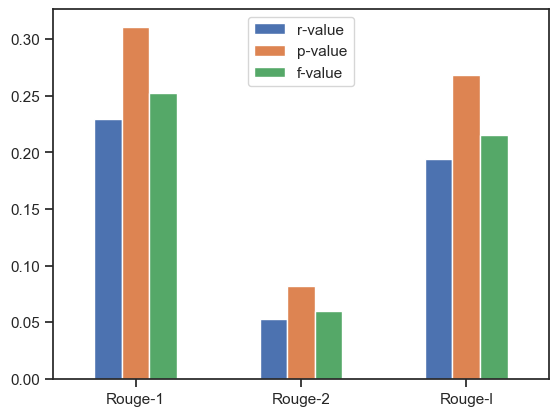

In [118]:
r = [0.22909554772856172, 0.05290011511223154, 0.1936992432838048]
p = [0.3108522817761948, 0.08163852910487383, 0.26845771076749336]
f = [0.25242390219736544, 0.059922804210279054, 0.21519446912981982]
index =['Rouge-1', 'Rouge-2', 'Rouge-l']

scores_average_r = pd.DataFrame({
    'r-value': r,
    'p-value':p,
    'f-value':f
}, index=index)

ax = scores_average_r.plot.bar(rot=0)


In [ ]:
# F-1(f), Precision(p), and Recall(r)
# Creating Tables and Boxplots

# Referencias: https://github.com/jamescalam/transformers/blob/main/course/question_answering/04_rouge.ipynb

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

df_scores = pd.DataFrame(scores)
df_scores_avg = pd.DataFrame(scores_average)


Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Boxplots w/ scores_average

# Reference: https://www.statology.org/seaborn-boxplot-multiple-columns/

In [90]:
# Rouge-1 collumn
df_scores_rouge_1 = df_scores['rouge-1'].to_list()

df_scores_rouge_1_r = [dicts['r'] for dicts in df_scores_rouge_1]
df_scores_rouge_1_p = [dicts['p'] for dicts in df_scores_rouge_1]
df_scores_rouge_1_f = [dicts['f'] for dicts in df_scores_rouge_1]


In [91]:
# Rouge-2 collumn
df_scores_rouge_2 = df_scores['rouge-2'].to_list()

df_scores_rouge_2_r = [dicts['r'] for dicts in df_scores_rouge_2]
df_scores_rouge_2_p = [dicts['p'] for dicts in df_scores_rouge_2]
df_scores_rouge_2_f = [dicts['f'] for dicts in df_scores_rouge_2]


In [92]:
# Rouge-l collumn
df_scores_rouge_L = df_scores['rouge-l'].to_list()

df_scores_rouge_L_r = [dicts['r'] for dicts in df_scores_rouge_L]
df_scores_rouge_L_p = [dicts['p'] for dicts in df_scores_rouge_L]
df_scores_rouge_L_f = [dicts['f'] for dicts in df_scores_rouge_L]


In [95]:
# Rouge-1 DataFrame 

df_rouge_1 = pd.DataFrame({
    'r': df_scores_rouge_1_r,
    'p': df_scores_rouge_1_p,
    'f': df_scores_rouge_1_f
})


,r,p,f
0,0.272727,0.272727,0.272727
1,0.261905,0.261905,0.261905
2,0.266667,0.685714,0.384000
3,0.166667,0.071429,0.100000
4,0.215385,0.304348,0.252252
5,0.185185,0.303030,0.229885
6,0.305085,0.327273,0.315789
7,0.239130,0.261905,0.250000
8,0.250000,0.307692,0.275862
9,0.128205,0.312500,0.181818


Text(0.5, 0, 'Rouge Metric')

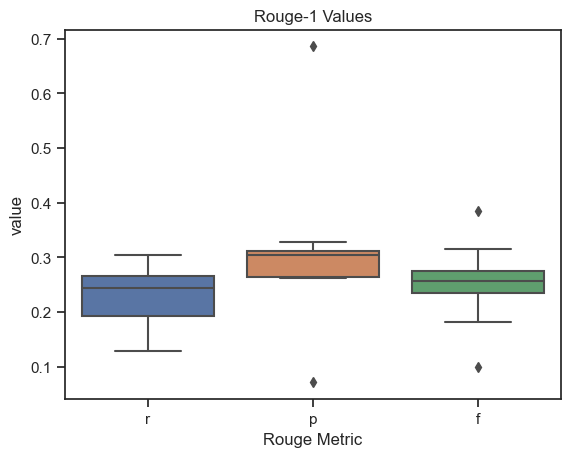

In [114]:
# Rouge-1 Box-plot
import seaborn as sns

df_rouge_1_melted = pd.melt(df_rouge_1)

#create seaborn boxplots by group
sns.boxplot(x='variable', y='value', data=df_rouge_1_melted).set(title='Rouge-1 Values')

#modify axis labels
plt.xlabel('Rouge Metric')

In [98]:
# Rouge-2 DataFrame

df_rouge_2 = pd.DataFrame({
    'r': df_scores_rouge_2_r,
    'p': df_scores_rouge_2_p,
    'f': df_scores_rouge_2_f
})

Text(0.5, 0, 'Rouge Metric')

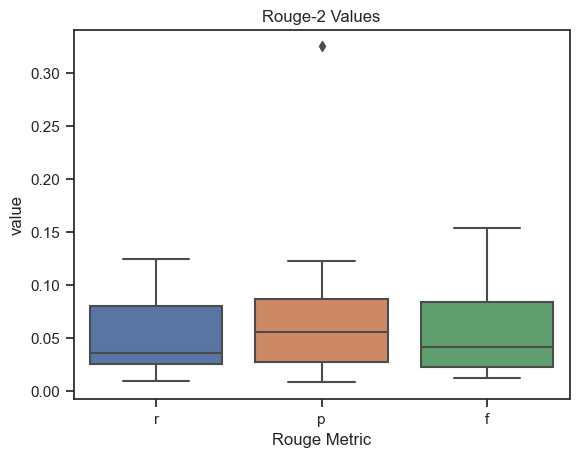

In [113]:
# Rouge-2 Box-plot

df_rouge_2_melted = pd.melt(df_rouge_2)

#create seaborn boxplots by group
sns.boxplot(x='variable', y='value', data=df_rouge_2_melted).set(title='Rouge-2 Values')

#modify axis labels
plt.xlabel('Rouge Metric')

In [101]:
# Rouge-L DataFrame

df_rouge_L = pd.DataFrame({
    'r': df_scores_rouge_L_r,
    'p': df_scores_rouge_L_p,
    'f': df_scores_rouge_L_f
})

Text(0.5, 0, 'Rouge Metric')

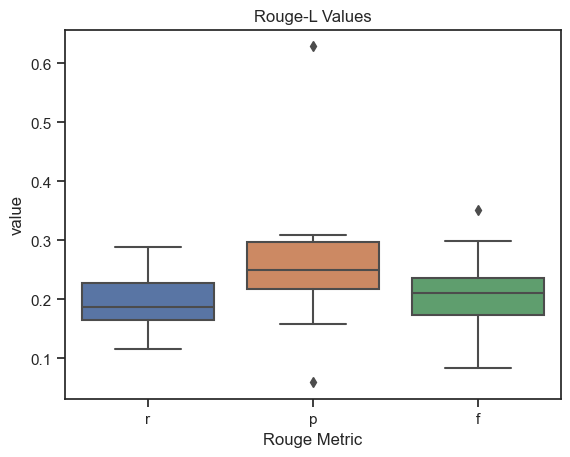

In [112]:
# Rouge-2 Box-plot

sns.set_theme(style="ticks", palette=None)

df_rouge_L_melted = pd.melt(df_rouge_L)

#create seaborn boxplots by group
sns.boxplot(x='variable', y='value', data=df_rouge_L_melted).set(title='Rouge-L Values')

#modify axis labels
plt.xlabel('Rouge Metric')